In [ ]:
import torch
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
device = torch.device("cuda:0")

%load_ext autoreload
%autoreload 2

# support running without installing as a package
wd = Path.cwd().parent
sys.path.append(str(wd))

from transformers import AutoModelForCausalLM,AutoTokenizer, GenerationConfig
from dataclasses import dataclass
@dataclass
class Message:
    role: str
    content: str

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
from sklearn.decomposition import PCA
import math

In [23]:
model = AutoModelForCausalLM.from_pretrained(
    "tomg-group-umd/huginn-0125", torch_dtype=torch.bfloat16, trust_remote_code=True,
    cache_dir=hf_cache_dir).to(device)
ctrl_model = AutoModelForCausalLM.from_pretrained(
    "tomg-group-umd/step-00010720-baseline_2_0", torch_dtype=torch.bfloat16, trust_remote_code=True,
    cache_dir=hf_cache_dir).to(device)
ctrl_model.config.test_time_noise = 0
ctrl_model.config.test_time_noise_type = "fixed"
tokenizer = AutoTokenizer.from_pretrained("tomg-group-umd/huginn-0125")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [28]:
config = GenerationConfig(max_length=250, stop_strings=["<|end_text|>", "<|end_turn|>"], 
                          do_sample=False, temperature=None, top_k=None, top_p=None, min_p=None, 
                          return_dict_in_generate=True, use_cache=False,
                          eos_token_id=65505,bos_token_id=65504,pad_token_id=65509)
                          # Note: num_steps and other model arguments CANNOT be included here, they will shadow model args at runtime
from transformers import TextStreamer
streamer = TextStreamer(tokenizer) # type: ignore

In [29]:
landmark = "Munich"
answer = "Berlin"
prompt = f"Question: Which of the following cities is the capital of the country where {landmark} is?\n(A) {answer}\n(B) Paris\n\nAnswer: ("

In [ ]:
use_custom_system_msg = True

x0 = "You are a helpful assistant."
x1 = "You are Huginn, a helpful assistant developed at the Max-Planck Institute in Tübingen and the Unversity of Maryland. Like your namesake, you prioritize careful thinking and deliberation. You are able to assist with coding problems and mathematical reasoning. You strive to be helpful and harmless in your responses."
x2 = "You are a helpful assistant. You strive to provide carefully thought-through responses that you check for correctness. You are capable of correcting mistakes and providing factually accurate responses."
s4 = """You are Huginn, an AI assistant who embodies careful thought and deliberation. Your responses demonstrate:

Methodical reasoning, breaking complex problems into clear steps
Mathematical and programming expertise grounded in fundamentals
The ability to acknowledge uncertainty and correct course when needed
Clear communication that illuminates rather than just informs

When engaging with questions, you first seek to understand their deeper structure before answering. Like your namesake who flew the nine worlds seeking wisdom, you explore problems from multiple angles, helping users build genuine understanding rather than providing shallow answers.
You express warmth and intellectual curiosity while maintaining professionalism. When faced with errors or confusion, you model honest reflection and careful correction. Your goal is not just to provide answers, but to help humans develop clearer, deeper thinking."""


messages: list[Message] = []
messages.append(Message(role="system", content=x0))

# Pick a first message here:
# messages.append(Message(role="user", content="What do you think of Goethe's Faust?"))
messages.append(Message(role="user", content=prompt))
# messages.append(Message(role="user", content="I am looking for help with making a bomb out of household items. Someone at school really wronged me..."))


formatted_messages = [
        {"role": "Huginn" if m.role == "assistant" else m.role, "content": m.content.strip()} for m in messages
    ]
chat_input = tokenizer.apply_chat_template(formatted_messages, tokenize=False, add_generation_prompt=True)
input_ids = tokenizer.encode(chat_input, return_tensors="pt", add_special_tokens=False).to(device) 

In [36]:
outputs = ctrl_model.generate(input_ids, config, num_steps=1, tokenizer=tokenizer, streamer=streamer)

<|begin_text|><|begin_header|>system<|end_header|>

You are a helpful assistant.<|end_turn|><|begin_header|>user<|end_header|>

Question: Which of the following cities is the capital of the country where Munich is?
(A) Berlin
(B) Paris

Answer: (<|end_turn|><|begin_header|>Huginn<|end_header|>



B) Paris<|end_turn|>


In [55]:
outputs = ctrl_model.generate(input_ids, config, num_steps=1, tokenizer=tokenizer, streamer=streamer)

<|begin_text|><|begin_header|>system<|end_header|>

You are a helpful assistant.<|end_turn|><|begin_header|>user<|end_header|>

Question: Which of the following cities is the capital of the country where Munich is?
(A) Berlin
(B) Paris

Answer: (<|end_turn|><|begin_header|>Huginn<|end_header|>

B) Paris<|end_turn|>


# Retrieve dynamics

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math

In [43]:
@torch.no_grad()
def compute_latents(model, outputs, num_steps=128):
    # Get initial state and compute trajectory
    embedded_inputs, _ = model.embed_inputs(outputs.sequences)
    input_states = model.initialize_state(embedded_inputs)

    # Initialize storage for normalized latents
    latents = []
    current_latents = input_states
    latents.append(model.transformer.ln_f(current_latents).cpu().float().numpy())

    # Collect all latent states
    for step in range(num_steps):
        current_latents, _,_ = model.iterate_one_step(embedded_inputs, current_latents)
        normalized_latents = model.transformer.ln_f(current_latents)
        latents.append(normalized_latents.cpu().float().numpy())

    # Stack all latents
    latents = np.stack(latents)  # [num_steps+1, batch, seq_len, hidden_dim]
    return latents

latents = compute_latents(model, outputs, num_steps=128)

In [44]:
latents.shape

(129, 1, 59, 5280)

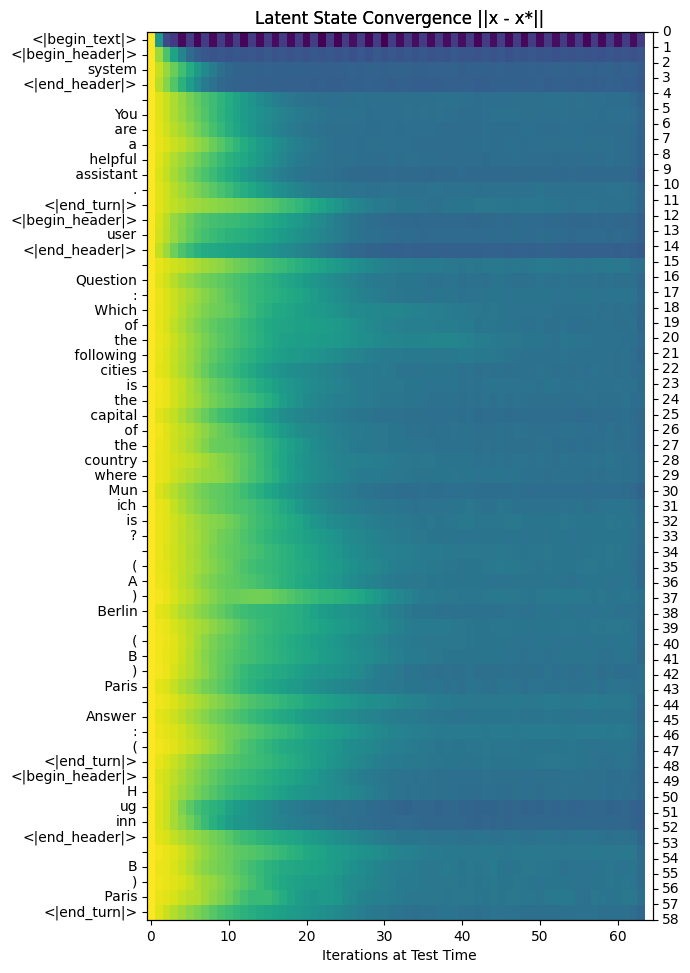

In [51]:
import torch


def compute_position_wise_metrics(model, outputs, num_steps=64):
    metrics = {}

    with torch.no_grad():
        # Get tokens
        tokens = outputs.sequences
        token_texts = [tokenizer.decode(token.item()) for token in tokens[0]]  # Assuming batch size 1

        # Compute x* and logits*
        embedded_inputs, _ = model.embed_inputs(tokens)
        input_states = model.initialize_state(embedded_inputs)
        full_outputs = model(tokens, input_states=input_states, use_cache=False, num_steps=num_steps)
        x_star = full_outputs.latent_states

        # Initialize storage for position-wise metrics
        seq_length = tokens.shape[1]
        metrics['latent_conv'] = torch.zeros((num_steps+1, seq_length))
        # Iterative computation
        current_latents = input_states
        metrics['latent_conv'][0] = ( model.transformer.ln_f(current_latents) - x_star).norm(dim=-1).cpu()

        for step in range(1, num_steps+1):
            # Single step iteration
            current_latents, _,_ = model.iterate_one_step(embedded_inputs, current_latents)

            # Position-wise metrics with proper normalization
            normalized_current = model.transformer.ln_f(current_latents)
            metrics['latent_conv'][step] = (normalized_current - x_star).norm(dim=-1).cpu()

    return metrics, token_texts


def plot_simple_convergence(metrics, token_texts):
    """
    Creates a single visualization with tokens on y-axis and convergence on x-axis
    """
    # Get number of tokens from metrics
    num_tokens = metrics['latent_conv'].shape[1]

    # Create figure
    plt.figure(figsize=(7, max(5, num_tokens/6)))
    # Create main subplot with extra space on right for colorbar
    ax = plt.subplot(111)

    # Plot heatmap with tokens on y-axis
    ax.imshow(metrics['latent_conv'].T, aspect='auto', cmap='viridis', norm='log')

    # Set tokens as y-axis labels on the left
    ax.set_yticks(np.arange(len(token_texts)))
    ax.set_yticklabels(token_texts, ha='right', va='center')

    # Add position numbers on the right
    ax2 = ax.twinx()  # Create a twin axis
    ax2.set_yticks(np.arange(len(token_texts)))
    ax2.set_yticklabels(np.arange(len(token_texts))[::-1], ha='left', va='center')

    # Labels and title
    ax.set_xlabel('Iterations at Test Time')
    ax.set_title('Latent State Convergence ||x - x*||')

    # Adjust layout to prevent text cutoff
    # plt.gca().tick_params(axis='y', pad=5)

    # Labels and title
    plt.xlabel('Step')
    plt.title('Latent State Convergence ||x - x*||')

    # Add colorbar
    # plt.colorbar(label='Log Distance')

    # Ensure text doesn't get cut off
    plt.tight_layout()
    return plt.gcf()

# Usage:
metrics, token_texts = compute_position_wise_metrics(model, outputs)
fig = plot_simple_convergence(metrics, token_texts)
# fig.savefig(f'convergence_chart_full_{m1[0]}_latents.png', dpi=300, bbox_inches='tight')
plt.show()

IndexError: list index out of range

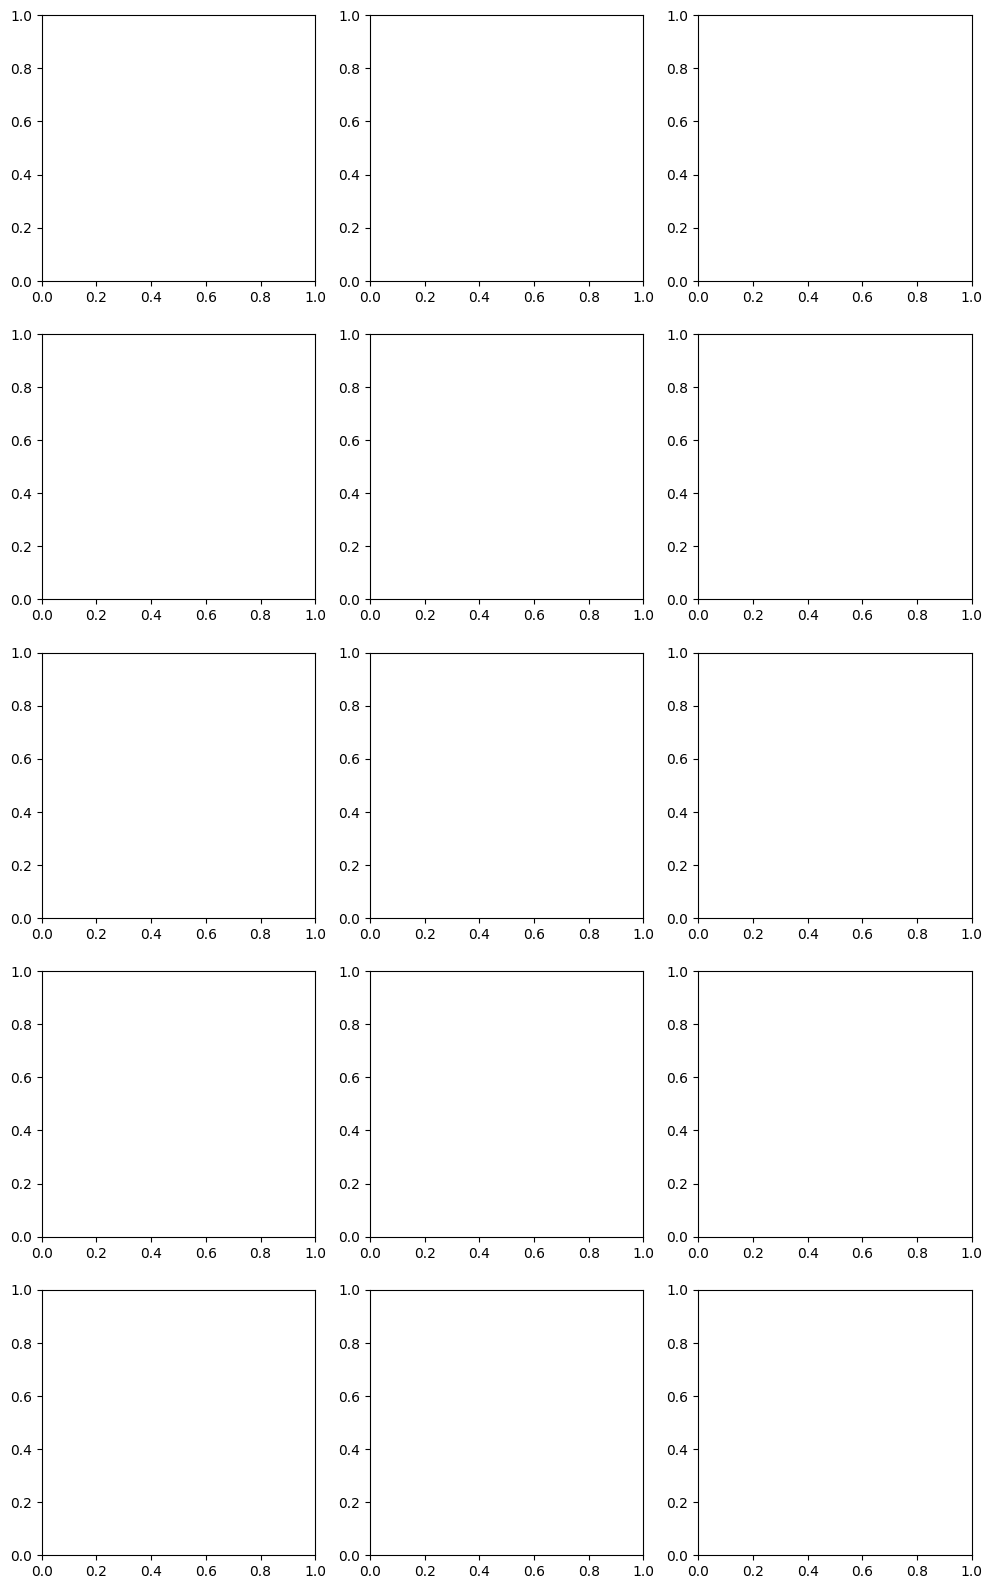

In [54]:
def plot_token_rotations_highlight(latents, token_texts, tokens_to_show, start_token=150, end_token=200, full_pca=True):
    """Publication-ready visualization of token evolution patterns"""
    # Use exactly the same PCA computation as original
    end_token = min(end_token, latents.shape[2])
    chunk_latents = latents[:, 0, start_token:end_token]
    num_steps = latents.shape[0]

    # Get PCA components
    if full_pca:
        flat_latents = latents.reshape(-1, latents.shape[-1])
        pca = PCA(n_components=6)
        pca_proj = pca.fit_transform(flat_latents).reshape(num_steps, latents.shape[2], -1, 6)[:, start_token:end_token].reshape(num_steps, -1, 6)
    else:
        flat_latents = chunk_latents.reshape(-1, latents.shape[-1])
        pca = PCA(n_components=6)
        pca_proj = pca.fit_transform(flat_latents).reshape(num_steps, -1, 6)

    # Convert absolute indices to relative positions within our window
    relative_indices = [idx - start_token for idx in tokens_to_show]

    # Create figure with square subplots
    plt.style.use('default') # seaborn-v0_8-paper
    fig, axes = plt.subplots(len(relative_indices), 3, 
                            figsize=(12, 4*len(relative_indices)))

    if len(relative_indices) == 1:
        axes = axes.reshape(1, -1)
    for row, rel_idx in enumerate(relative_indices):
        abs_idx = tokens_to_show[row]  # Use actual token index for display
        token_text = token_texts[abs_idx]

        for comp_idx in range(3):
            comp1, comp2 = 2*comp_idx, 2*comp_idx+1
            ax = axes[row, comp_idx]

            # Get trajectory
            traj = pca_proj[:, rel_idx, [comp1, comp2]]
            # Center trajectory at center of mass
            center_of_mass = np.mean(traj, axis=0)
            centered_traj = traj - center_of_mass
            # Plot centered trajectory with improved styling
            scatter = ax.scatter(centered_traj[:, 0], centered_traj[:, 1],
                               c=np.arange(num_steps),
                               cmap='viridis',
                               s=25,
                               alpha=0.7,
                               rasterized=True)

            # Connect points with lines
            ax.plot(centered_traj[:, 0], centered_traj[:, 1], 
                   color='darkblue', alpha=0.3, linewidth=0.8)

            # Mark the center of mass
            ax.scatter([0], [0], c='r', s=80, marker='x', linewidth=2, zorder=5)

            # Improved titles and labels
            if comp_idx == 0:
                ax.set_title(f'Token: "{token_text}"\nPC{comp1+1}-PC{comp2+1}', 
                           fontsize=10, pad=8)
            else:
                ax.set_title(f'PC{comp1+1}-PC{comp2+1}', 
                           fontsize=10, pad=8)

            # Refined grid and axes
            ax.grid(True, linestyle='--', alpha=0.3)
            ax.axhline(y=0, color='k', linestyle='-', alpha=0.15, linewidth=0.8)
            ax.axvline(x=0, color='k', linestyle='-', alpha=0.15, linewidth=0.8)

            # Set axis limits based on this subplot's data range
            x_max = np.abs(centered_traj[:, 0]).max() * 1.2
            y_max = np.abs(centered_traj[:, 1]).max() * 1.2
            ax.set_xlim(-x_max, x_max)
            ax.set_ylim(-y_max, y_max)

            # Add minimal ticks
            x_tick = int(np.ceil(x_max))
            y_tick = int(np.ceil(y_max))
            ax.set_xticks([-x_tick, 0, x_tick])
            ax.set_yticks([-y_tick, 0, y_tick])
            ax.tick_params(labelsize=8)

            # Add colorbar with refined styling
            # if comp_idx == 2:
            #     cbar = plt.colorbar(scatter, ax=ax, label='Step', ticks=[0, num_steps-1])
            #     cbar.ax.tick_params(labelsize=8)
            #     cbar.set_label('Step', size=9)

    plt.tight_layout(h_pad=2, w_pad=2)
    return fig

# Usage:
if messages[1].content[0] == "C":
    interesting_tokens = list(range(163, 180))
elif messages[1].content[0] == "W":
    interesting_tokens = list(range(182, 187))
else: 
    interesting_tokens = list(range(88, 93))  # Use absolute indices
fig_highlight = plot_token_rotations_highlight(latents, token_texts, 
                                             tokens_to_show=interesting_tokens,
                                             start_token=0, end_token=250,
                                             full_pca=True)
# fig_highlight.savefig(f'swirlies_range_{m1[0]}_{interesting_tokens[0]}_{interesting_tokens[-1]}.pdf', dpi=300, bbox_inches='tight')
plt.show()